In [1]:
# Importamos las librerías necesarías y fijamos la semilla.
import numpy as np
import random
import scipy
from scipy.stats import uniform as spuniform
import matplotlib.pyplot as plt
import collections

from matplotlib import pyplot
import math
import statistics
import pandas as pd
import time
!pip install networkx
import networkx as nx
import os
import re
from matplotlib import colors

np.random.seed(11)

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Calcula cuánto tiempo ha pasado desde un momento dado hasta el momento actual.
def timeSince(since):
    now = time.time_ns()
    s = now - since
    return s*10**(-9)

Definimos un función que entrega un grafo a partir de un número de vertices V y un a lista de aristas con sus pesos correspondientes.

In [3]:
def grafo(V,E):
    G = nx.Graph()
    G.add_nodes_from(range(V))
    G.add_edges_from([(key[0],key[1],{"weight": E[key]}) for key in list(E.keys())])
    return G 

In [4]:
def costo(ruta,distancias):
    return np.sum(distancias[ruta[i],ruta[i+1]] for i in range(len(ruta)-1))

In [5]:
# Beta lineal
def beta1(n,C):
    return n/C

# Beta cuadrático.
def beta2(n,C):
    return (n**2)/C

# Beta exponencial.
def beta3(n,C):
    return np.exp(n)/C

Se define una función que grafica el camino sobre un grafo G.

In [6]:
def plotear(G,camino):
    plt.figure()
    plt.scatter([ciudades[i][0] for i in range(len(P))],[ciudades[i][1] for i in range(len(P))], marker="o")
    for i in range(len(sigma)-1):
        plt.plot([ciudades[sigma[i]][0],ciudades[sigma[i+1]][0]],[ciudades[sigma[i]][1],ciudades[sigma[i+1]][1]],'k-')

Definimos una función que entrega un grafo regular de n vértices, todos de grado d. Los pesos de las aristas son asignados aleaoriamente entre el 1 y el 100.

In [7]:
def graforegular(d,n):
    G = nx.random_regular_graph(d,n)
    for e in G.edges():
        G[e[0]][e[1]]["weight"] = np.random.randint(1,100)
    return G

Función que realiza el Simulated Annealing dado un grafo G, configuración inicial $\sigma_0$, y sus parámetros: C, $\beta_n$ y número de pasos.

In [8]:
def SimAnn(G,sigma0,C,beta,pasos=10**4):
    inicial= sigma0[0]
    final= sigma0[-1]
    # Se define las uniformes para cada paso.
    U = np.random.uniform(size = pasos)
    sigmas = [sigma0]
    w = [nx.path_weight(G,sigma0,"weight")]
    conteo=0
    for i in range(pasos-1):
        # Configuración anterior.
        sigma= sigmas[i]
        # Definimos beta_n según la función dada.
        betan= beta(i,C)
        # Sacamos un vecino como otra cosa más rara.
        x = random.choice(sigma[:-1])
        index = min(np.where(np.array(sigma) == x)[0])
        caminos= []
        for node in sigma[index+1:]:
            caminos.extend(list(nx.all_simple_paths(G,x,node,2)))
        add = random.choice(caminos)
        tau = sigma[:index]
        tau.extend(add)
        indexf = min(np.where(np.array(sigma) == add[-1])[0])
        tau.extend(sigma[indexf+1:])
        # Remove loops.
        loops = [item for item, count in collections.Counter(tau).items() if count > 1]
        while len(loops)>0:
            copia = loops[0]
            borrar1 = min(np.where(np.array(tau) == copia)[0])
            borrar2 = max(np.where(np.array(tau) == copia)[0])
            del tau[borrar1:borrar2]
            loops = [item for item, count in collections.Counter(tau).items() if count > 1]
        # Costo anterior.
        ws = nx.path_weight(G,sigma,"weight")
        # Costo vecino.
        wt = nx.path_weight(G,tau,"weight")
        dif = np.exp(-betan*(wt-ws))
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(wt)
        else:
            sigmas.append(sigma)
            w.append(ws)
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas

Función auxiliar para leer archivos de formato .stp

In [9]:
def read_stp(file_name):
    with open(file_name) as f:
        lines = f.readlines()

        sections = "Comment Graph Terminals".split()
        current_section = ""
        n, m = 0, 0
        col_s = []  # node source
        col_t = []  # node target
        col_w = []  # weight fun
        terminals = []
        for l in lines:
            if "SECTION" in l:
                current_section = l.replace("SECTION", "").strip()
            elif "END" in l:
                current_section = ""
            elif current_section == "Graph":
                if "Nodes" in l:
                    n = int(re.findall(r"\d+", l)[0])
                elif "Edges" in l:
                    m = int(re.findall(r"\d+", l)[0])
                elif "E" in l:
                    s, t, w_st = re.findall(r"\d+", l)
                    s, t, w_st = int(s), int(t), int(w_st)
                    col_s.append(s)
                    col_t.append(t)
                    col_w.append(w_st)
            elif current_section == "Terminals":
                if "T " in l:
                    terminals.append(int(re.findall(r"\d+", l)[0]))

        df_edges_G = pd.DataFrame({
            "SOURCE": col_s,
            "TARGET": col_t,
            "WEIGHT": col_w
        })

        return df_edges_G, terminals

## Implementación

Comenzamos con un grafo conexo de 4 vértices, para encontrar su solución de forma manual más fácil y verificar si el Simulated Annealing puede obtener el óptimo.

In [10]:
dic = {(0,1): 4, (0,2):7,(0,3): 10, (1,2): 2, (1,3): 5, (2,3): 2}
G  = grafo(4,dic)
# Solución por Dijkstra.
p = nx.shortest_path(G,0,3,"weight")
ruta = [0,1,3]
pasos = 10**2
# Solución por S.A.
s,w,W,S = SimAnn(G,ruta,10,beta2,pasos)
print(s)
print(p)

[0, 1, 2, 3]
[0, 1, 2, 3]


Observamos el grafo y sus soluciónes:

{(0, 1): Text(0.09815341261576085, -0.18489824461931026, '4'),
 (0, 2): Text(0.019018949370788796, 0.6776184231347513, '7'),
 (0, 3): Text(-0.5510312113990173, -0.13748333224593828, '10'),
 (1, 2): Text(0.5510312113990178, 0.1374833322459384, '2'),
 (1, 3): Text(-0.019018949370788296, -0.6776184231347513, '5'),
 (2, 3): Text(-0.09815341261576035, 0.18489824461931037, '2')}

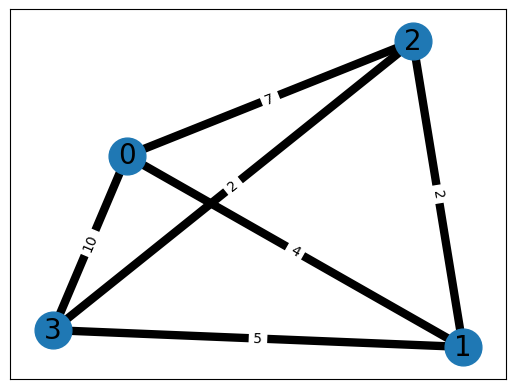

In [11]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=700)

nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(0.06264430433733939, 0.226041636022335, '4'),
 (0, 2): Text(0.1660613511149557, -0.734167317469999, '7'),
 (0, 3): Text(-0.6327247896264638, 0.03979104650766607, '10'),
 (1, 2): Text(0.6327247896264635, -0.03979104650766596, '2'),
 (1, 3): Text(-0.166061351114956, 0.7341673174699992, '5'),
 (2, 3): Text(-0.0626443043373397, -0.2260416360223349, '2')}

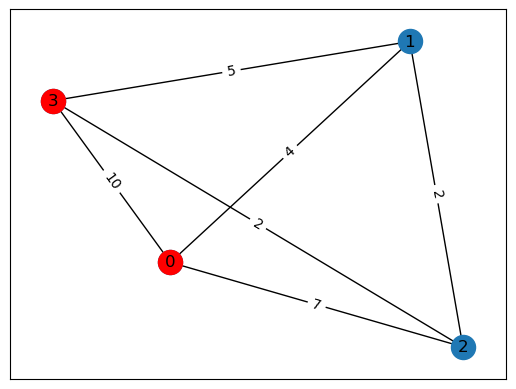

In [12]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,3], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(0.2433512290237222, -0.04781550370430443, '4'),
 (0, 2): Text(-0.7539442021872165, -0.2284225459000532, '7'),
 (0, 3): Text(-0.002704568789060835, 0.665552086241902, '10'),
 (1, 2): Text(0.0027045687890613346, -0.6655520862419023, '2'),
 (1, 3): Text(0.7539442021872169, 0.22842254590005293, '5'),
 (2, 3): Text(-0.2433512290237217, 0.04781550370430415, '2')}

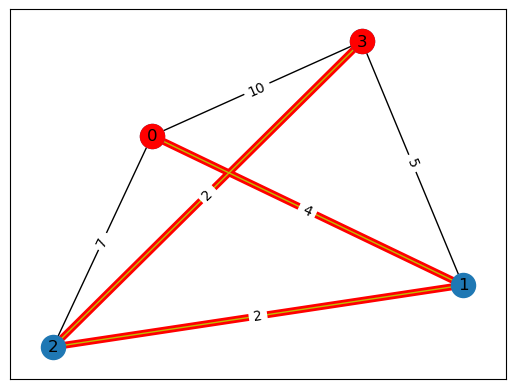

In [13]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,3], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_edges(G,pos=pos,edgelist=edges,edge_color = "r",width=5)
nx.draw_networkx_edges(G,pos=pos,edgelist=edgep,edge_color = "y")
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

Ahora implementamos Simulated Annealing en un grafo más complicado: uno conexo de 7 vértices.

In [14]:
dic = {(0,1): 2, (0,2):4,(0,3): 3, (0,5):6, (1,3): 7, (1,4): 2,(1,6): 8, (2,3): 2, (2,4):3, (2,6):6, (3,5):6, (4,5):1, (4,6):5, (5,6):3}
G  = grafo(7,dic)
ruta = [0,2,3,5,6]
pasos = 10**2
# Solución por S.A.
s,w,W,S = SimAnn(G,ruta,10,beta2,pasos)
# Solución por Dijkstra.
p = nx.shortest_path(G,0,6,"weight")
print(p)
print(s)


[0, 1, 4, 5, 6]
[0, 5, 6]


Observamos el grafo y sus soluciónes:

{(0, 1): Text(-0.07241846320193548, 0.34574848623040616, '2'),
 (0, 2): Text(0.4688891338082407, 0.26063305532914854, '4'),
 (0, 3): Text(0.023988685534587134, 0.6812988853771728, '3'),
 (0, 5): Text(0.26017312168533596, 0.5330759908549141, '6'),
 (1, 3): Text(-0.4801746932692407, 0.31015599998118154, '7'),
 (1, 4): Text(-0.24188902941693446, -0.5126971995827926, '2'),
 (1, 6): Text(-0.3677079170122182, -0.25811655993483906, '8'),
 (2, 3): Text(0.061132903740935496, 0.22504056907992392, '2'),
 (2, 4): Text(0.29941856759324176, -0.5978126304840501, '3'),
 (2, 6): Text(0.173599679997958, -0.3432319908360967, '6'),
 (3, 5): Text(-0.14758310838196925, 0.49748350460568946, '6'),
 (4, 5): Text(0.09070255547033701, -0.3253696949582846, '1'),
 (4, 6): Text(-0.03301510442338933, -0.7454193603520465, '5'),
 (5, 6): Text(-0.03511633212494676, -0.07078905531033117, '3')}

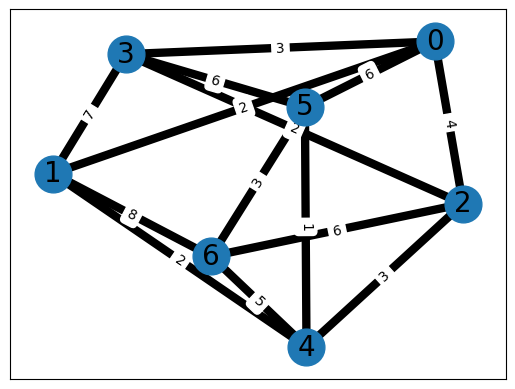

In [15]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=700)

nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

# Edges.
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(-0.08238345360255411, 0.19710198739799462, '2'),
 (0, 2): Text(0.5473468247539018, 0.18640846017486876, '4'),
 (0, 3): Text(-0.028569800094470466, 0.5419498562945851, '3'),
 (0, 5): Text(0.20268003099467027, 0.6689329599089353, '6'),
 (1, 3): Text(-0.5702546412398783, 0.1380402672868811, '7'),
 (1, 4): Text(-0.24802441086391086, -0.6034038008048548, '2'),
 (1, 6): Text(-0.3261654046213177, -0.2962796999726912, '8'),
 (2, 3): Text(0.05947563711657761, 0.12734674006375524, '2'),
 (2, 4): Text(0.3817058674925451, -0.6140973280279806, '3'),
 (2, 6): Text(0.30356487373513824, -0.30697322719581704, '6'),
 (3, 5): Text(-0.28519115664265393, 0.6098712397978219, '6'),
 (4, 5): Text(0.03703907373331351, -0.13157282829391398, '1'),
 (4, 6): Text(0.0498784792627334, -0.6928758991678364, '5'),
 (5, 6): Text(-0.04110192002409333, 0.17555127253824956, '3')}

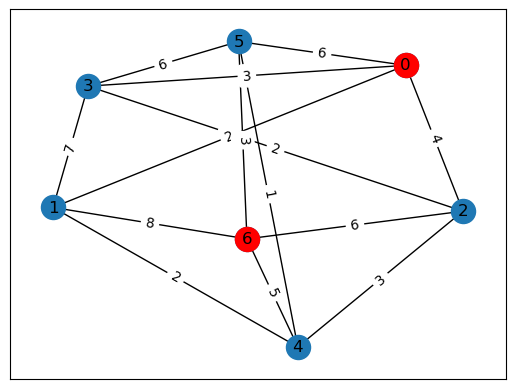

In [16]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,6], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

{(0, 1): Text(0.3080401268809186, 0.29269116000791817, '2'),
 (0, 2): Text(-0.27471357394617535, 0.5784897313962997, '4'),
 (0, 3): Text(0.4592027534010366, 0.6880236436658402, '3'),
 (0, 5): Text(0.12578957178661723, 0.6891838812336342, '6'),
 (1, 3): Text(0.6880138172880003, -0.019285196326241538, '7'),
 (1, 4): Text(-0.13771643779675696, -0.656436061836416, '2'),
 (1, 6): Text(0.1750923449331735, -0.5065700344514401, '8'),
 (2, 3): Text(0.10526011646090633, 0.2665133750621399, '2'),
 (2, 4): Text(-0.7204701386238509, -0.3706374904480345, '3'),
 (2, 6): Text(-0.40766135589392044, -0.2207714630630586, '6'),
 (3, 5): Text(0.5057632621936989, 0.37720752489947446, '6'),
 (4, 5): Text(-0.3199669928910583, -0.25994334061069996, '1'),
 (4, 6): Text(-0.4994752836314657, -0.7483884163036923, '5'),
 (5, 6): Text(-0.007158210161127818, -0.11007731322572406, '3')}

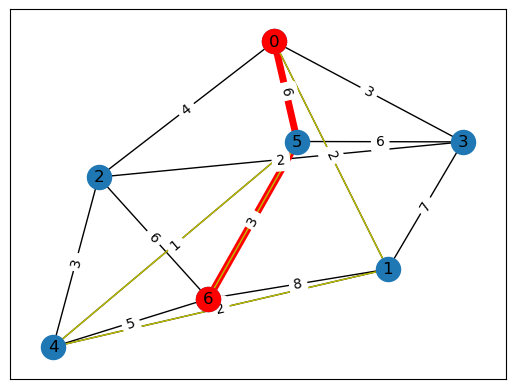

In [17]:
pos = nx.spring_layout(G)
edges = [(s[i],s[i+1]) for i in range(len(s)-1)]
edgep = [(p[i],p[i+1]) for i in range(len(p)-1)]

nx.draw_networkx_nodes(G,pos=pos)

nx.draw_networkx_nodes(G,pos=pos,nodelist=[0,6], node_color="r")

nx.draw_networkx_edges(G,pos=pos,edgelist=G.edges())
nx.draw_networkx_edges(G,pos=pos,edgelist=edges,edge_color = "r",width =5)

nx.draw_networkx_edges(G,pos=pos,edgelist=edgep,edge_color = "y")
nx.draw_networkx_labels(G,pos=pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

## Implementación en Grafos aleatorios

Creamos un grafo regular cualquiera e implementamos Simulated Annealing para distintos valores de c y funciones $\beta$:

In [18]:
G = graforegular(30,80)
p = nx.shortest_path(G,6,25,"weight")
w = nx.path_weight(G,p,"weight")
ruta = random.choice(list(nx.all_simple_paths(G,6,25,5)))

In [19]:
c = [1,5,10,100]
pasos = [10**2, 10**3, 10**4,10**5]
i=3

s10,w10,W10,S10 = SimAnn(G,ruta,c[0],beta1,pasos[i])
s11,w11,W11,S11 = SimAnn(G,ruta,c[1],beta1,pasos[i])
s12,w12,W12,S12 = SimAnn(G,ruta,c[2],beta1,pasos[i])
s13,w13,W13,S13 = SimAnn(G,ruta,c[3],beta1,pasos[i])

s20,w20,W20,S20 = SimAnn(G,ruta,c[0],beta2,pasos[i])
s21,w21,W21,S21 = SimAnn(G,ruta,c[1],beta2,pasos[i])
s22,w22,W22,S22 = SimAnn(G,ruta,c[2],beta2,pasos[i])
s23,w23,W23,S23 = SimAnn(G,ruta,c[3],beta2,pasos[i])

s30,w30,W30,S30 = SimAnn(G,ruta,c[0],beta3,pasos[i])
s31,w31,W31,S31 = SimAnn(G,ruta,c[1],beta3,pasos[i])
s32,w32,W32,S32 = SimAnn(G,ruta,c[2],beta3,pasos[i])
s33,w33,W33,S33 = SimAnn(G,ruta,c[3],beta3,pasos[i])

C:\Users\nico_\AppData\Local\Temp\ipykernel_16688\3678309533.py:37: RuntimeWarning: overflow encountered in exp
  dif = np.exp(-betan*(wt-ws))
C:\Users\nico_\AppData\Local\Temp\ipykernel_16688\3678309533.py:37: RuntimeWarning: overflow encountered in double_scalars
  dif = np.exp(-betan*(wt-ws))
C:\Users\nico_\AppData\Local\Temp\ipykernel_16688\2028244564.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(n)/C
C:\Users\nico_\AppData\Local\Temp\ipykernel_16688\3678309533.py:37: RuntimeWarning: invalid value encountered in double_scalars
  dif = np.exp(-betan*(wt-ws))


Observamos el peso total para cada camino encontrado y se compara con el resultado encontrado por Dijkstra:

In [20]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [nx.path_weight(G,s10,"weight"),nx.path_weight(G,s20,"weight"), nx.path_weight(G,s30,"weight")],"C=5": [nx.path_weight(G,s11,"weight"), nx.path_weight(G,s21,"weight"), nx.path_weight(G,s31,"weight")] 
    ,"C=10": [nx.path_weight(G,s12,"weight"), nx.path_weight(G,s22,"weight"), nx.path_weight(G,s32,"weight")],"C=100": [nx.path_weight(G,s13,"weight"), nx.path_weight(G,s23,"weight"), nx.path_weight(G,s33,"weight")], "Dijkstra": [nx.path_weight(G,p,"weight") for i in range(3)]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100,Dijkstra
0,Lineal,18,18,25,45,18
1,Cuadrático,18,45,18,45,18
2,Exponencial,45,18,45,18,18


Observamos la evolución de los costos en cada paso para cada Simulated Annealing:

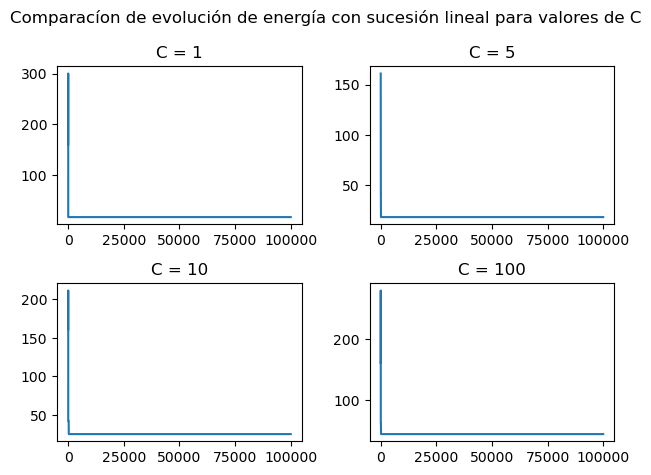

In [21]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(X,W10)
axs[0,1].plot(X,W11)
axs[1,0].plot(X,W12)
axs[1,1].plot(X,W13)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')

fig.suptitle("Comparacíon de evolución de energía con sucesión lineal para valores de C")
fig.tight_layout()

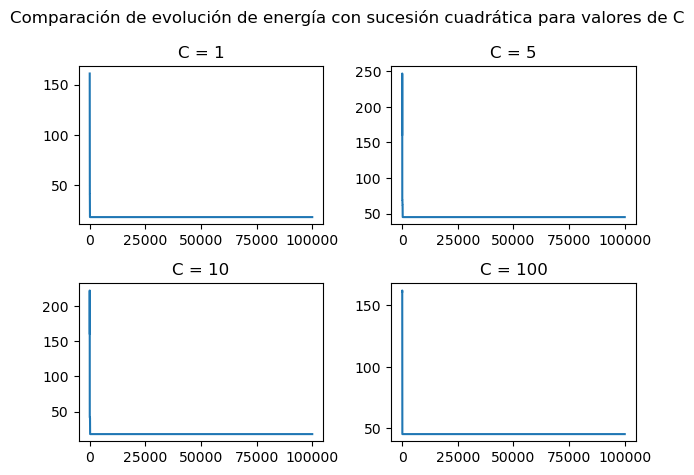

In [22]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(X,W20)
axs[0,1].plot(X,W21)
axs[1,0].plot(X,W22)
axs[1,1].plot(X,W23)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')
fig.suptitle("Comparación de evolución de energía con sucesión cuadrática para valores de C")
fig.tight_layout()

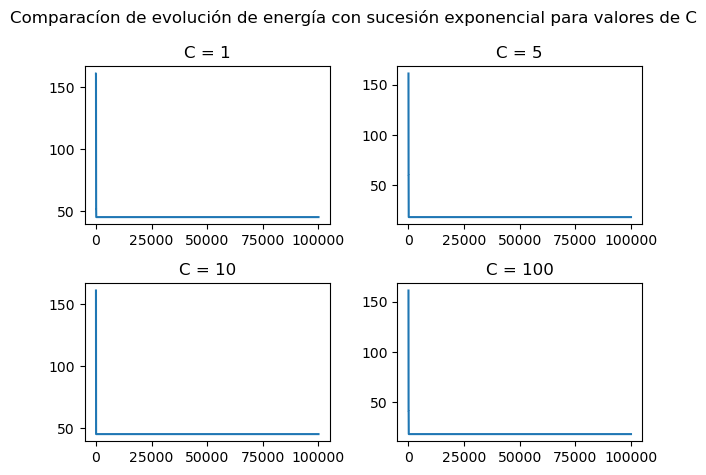

In [23]:
X = range(pasos[i])
fig, axs = plt.subplots(2, 2)
axs[0,0].plot(X,W30)
axs[0,1].plot(X,W31)
axs[1,0].plot(X,W32)
axs[1,1].plot(X,W33)
axs[0,0].set_title('C = 1')
axs[0,1].set_title('C = 5')
axs[1,0].set_title('C = 10')
axs[1,1].set_title('C = 100')
fig.suptitle("Comparacíon de evolución de energía con sucesión exponencial para valores de C")
fig.tight_layout()

Definimos la función simulación, el cual entrega N iteraciones para cada Annealing presentado (según sus parámetros) buscando soluciones sobre un grafo regular de n nodos con grado P. En cada iteración, define un nuevo nodo inicial y nodo final para correr los 12 Annealings.

In [24]:
def simulacion(N):
    GO = time.time_ns()    
    accs = {0:0, 1:0, 2:0,3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0}
    times = {0:[], 1:[], 2:[],3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
    # N nodos.
    n = 50
    # Grado.
    P = 15
    G = graforegular(P,n)
    c = [1,5,10,100]
    pasos = [10**2, 10**3, 10**4]
    dijkstras = []
    tiempos = []
    acc=0
    for u in range(N):
        print("Iteración:", u)
        ini = random.choice(range(n))
        fin = random.choice([h for h in range(n) if h!= ini])
        # Calculamos Dijkstra.
        start = time.time_ns()
        # Dijkstra.
        p = nx.shortest_path(G,ini,fin,"weight")
        # t Dijkstra.
        td = timeSince(start)
        dijkstras.append(td)
        W = nx.path_weight(G,p,"weight")
        t = []
        s = []
        w = []
        # Ruta inicial.
        ruta = random.choice(list(nx.all_simple_paths(G,ini,fin,3)))
        for i in range(len(c)):
            start = time.time_ns()
            # Lineal.
            s0,w0,W0,S0 = SimAnn(G,ruta,c[i],beta1,pasos[2])
            t0 = timeSince(start)
            start = time.time_ns()
            # Cuadrática.
            s1,w1,W1,S1 = SimAnn(G,ruta,c[i],beta2,pasos[2])
            t1 = timeSince(start)
            start = time.time_ns()
            # Exponencial.
            s2,w2,W2,S2 = SimAnn(G,ruta,c[i],beta3,pasos[2])
            t2 = timeSince(start)
            t.extend([t0,t1,t2])
            s.extend([s0,s1,s2])
            w.extend([w0,w1,w2])
        T = sum(t)/len(t)
        k=0
        for j in range(len(w)):
            if w[j] ==W  :
                accs[j] += 1
                times[j].append(t[j])
                if k==0:
                    acc+=1
                    k==1
        tiempos.append(T)
    for i in range(12):
        accs[i]=accs[i]/N
        times[i]=sum(times[i])/len(times[i])
    acc = acc/N
    avgtd = sum(dijkstras)/len(dijkstras)
    avgt = sum(tiempos)/len(tiempos)
    tfinal = timeSince(GO)
    return acc,avgtd, avgt,tfinal,accs,times

Implementamos 50 simulaciones y presentamos la precisión total (en cuantos problemas distintos alcanzó al menos un Annealing llegar al óptimo), el tiempo promedio que tardaron en encontrar la solución los métodos deterministas, y el tiempo promedio que tardaron los Annealings.

In [25]:
acc, avgtd, avgt, tfinal,accs,times = simulacion(50)
print("Accuracy:", acc)
print("Promedio Tiempo Dijkstra:", avgtd)
print("Promedio Tiempo S.A.:", avgt)
print("Promedio TOTAL:", tfinal)

Iteración: 0


C:\Users\nico_\AppData\Local\Temp\ipykernel_16688\3678309533.py:37: RuntimeWarning: overflow encountered in exp
  dif = np.exp(-betan*(wt-ws))
C:\Users\nico_\AppData\Local\Temp\ipykernel_16688\3678309533.py:37: RuntimeWarning: overflow encountered in double_scalars
  dif = np.exp(-betan*(wt-ws))
C:\Users\nico_\AppData\Local\Temp\ipykernel_16688\2028244564.py:11: RuntimeWarning: overflow encountered in exp
  return np.exp(n)/C
C:\Users\nico_\AppData\Local\Temp\ipykernel_16688\3678309533.py:37: RuntimeWarning: invalid value encountered in double_scalars
  dif = np.exp(-betan*(wt-ws))


Iteración: 1
Iteración: 2
Iteración: 3
Iteración: 4
Iteración: 5
Iteración: 6
Iteración: 7
Iteración: 8
Iteración: 9
Iteración: 10
Iteración: 11
Iteración: 12
Iteración: 13
Iteración: 14
Iteración: 15
Iteración: 16
Iteración: 17
Iteración: 18
Iteración: 19
Iteración: 20
Iteración: 21
Iteración: 22
Iteración: 23
Iteración: 24
Iteración: 25
Iteración: 26
Iteración: 27
Iteración: 28
Iteración: 29
Iteración: 30
Iteración: 31
Iteración: 32
Iteración: 33
Iteración: 34
Iteración: 35
Iteración: 36
Iteración: 37
Iteración: 38
Iteración: 39
Iteración: 40
Iteración: 41
Iteración: 42
Iteración: 43
Iteración: 44
Iteración: 45
Iteración: 46
Iteración: 47
Iteración: 48
Iteración: 49
Accuracy: 4.0
Promedio Tiempo Dijkstra: 0.00022004800000000006
Promedio Tiempo S.A.: 1.168498690166667
Promedio TOTAL: 701.1541424000001


Observamos el resumen de las 50 Simulaciones:

### Precisión de los métodos de Simulated Annealing

In [26]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [accs[0], accs[1], accs[2]],"C=5": [accs[3], accs[4], accs[5]] 
    ,"C=10": [accs[6],accs[7],accs[8]],"C=100": [accs[9], accs[10],accs[11]]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100
0,Lineal,0.36,0.32,0.30,0.38
1,Cuadrático,0.32,0.28,0.32,0.36
2,Exponencial,0.36,0.32,0.34,0.34



### Tiempo de ejecución promedio de los métodos de Simulated Annealing que alcanzaron el óptimo

In [27]:
d = {"Método": ["Lineal", "Cuadrático", "Exponencial"] , "C=1": [times[0], times[1], times[2]],"C=5": [times[3], times[4], times[5]] 
    ,"C=10": [times[6],times[7],times[8]],"C=100": [times[9], times[10],times[11]]}
df = pd.DataFrame(d)
df

,Método,C=1,C=5,C=10,C=100
0,Lineal,1.096383,1.051795,1.048176,1.085224
1,Cuadrático,1.062380,1.000236,1.047069,1.109505
2,Exponencial,1.152283,1.100804,1.121515,1.142690


### Anexo: Funciones de Simulated Annealing previas a la oficial

In [28]:
def SimAnn2(G,sigma0,C,beta,pasos=10**4):
    inicial= sigma0[0]
    final= sigma0[-1]
    # Se definen las uniformes para cada paso.
    U = np.random.uniform(size = pasos)
    sigmas = [sigma0]
    w = [nx.path_weight(G,sigma0,"weight")]
    conteo=0
    for i in range(pasos-1):
        # Configuración anterior.
        sigma= sigmas[i]
        # Definimos beta_n según la función dada.
        betan= beta(i,C)
        # Sacamos un vecino como un camino cualquiera.
        tau= [0]
        while tau[-1] != sigma[-1]:
            x = random.choice([a for a in G.neighbors(tau[-1]) if a not in tau])
            tau.append(x)     
        # Costo anterior.
        ws = nx.path_weight(G,sigma,"weight")
        # Costo vecino.
        wt = nx.path_weight(G,tau,"weight")
        dif = np.exp(-betan*(wt-ws))
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(wt)
        else:
            sigmas.append(sigma)
            w.append(ws)
    print("transiciones hechas:",conteo)
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas

In [29]:
def SimAnn3(G,sigma0,C,beta,pasos=10**4):
    inicial= sigma0[0]
    final= sigma0[-1]
    # Se definen las uniformes para cada paso.
    U = np.random.uniform(size = pasos)
    sigmas = [sigma0]
    w = [nx.path_weight(G,sigma0,"weight")]
    conteo=0
    for i in range(pasos-1):
        # Configuración anterior.
        sigma= sigmas[i]
        # Definimos beta_n según la función dada.
        betan= beta(i,C)
        # Sacamos un vecino.
        if len(sigma)==2:
            tau = random.choice(list(nx.all_simple_paths(G, source=sigma[0], target=sigma[-1])))
        else:
            # Elegir nodo a sacar.
            x =np.random.randint(1,len(sigma)-1)
            v = sigma[x-1]
            V = sigma[x+1]
            H = G.subgraph([n for n in list(G.nodes()) if n not in sigma].extend([v,V]))
            caminos = list(nx.all_simple_paths(H, source=v, target=V))
            if len(caminos)==1:
                t= caminos[0]
            else:
                t = random.choice(caminos)
            tau = sigma[:x]
            tau.extend(t[1:-1])
            tau.extend(sigma[x+1:])
        # Costo anterior.
        ws = nx.path_weight(G,sigma,"weight")
        # Costo vecino.
        wt = nx.path_weight(G,tau,"weight")
        dif = np.exp(-betan*(wt-ws))
        if U[i] <= min(dif,1):
            conteo +=1
            sigmas.append(tau)
            w.append(wt)
        else:
            sigmas.append(sigma)
            w.append(ws)
        
    print("transiciones hechas:",conteo)
    return sigmas[len(sigmas)-1] , w[len(sigmas)-1], w , sigmas

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45a688e7-b6e2-4e4a-b3a9-c39f5b699a07' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>